In [ ]:
# 8cluster_6_train
# 北車，共1個
# 8cluster_7_train.shape  => (58716, 14)
# 8cluster_7_test.shape => (30660, 14)

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MRT_8cluster_6_train = pd.read_csv('C:/Users/ching/Desktop/final project/data/MRT_Data_complete_0819/8cluster_6/8cluster_6_train.csv')

In [92]:
#MRT_8cluster_6_train['Sum_people'] = MRT_8cluster_6_train['Get_In_Count']+MRT_8cluster_6_train['Way_Out_Count']
MRT_8cluster_6_train.head()

,Unnamed: 0,Unnamed: 0.1,Date,Time,Station,Get_In_Count,Way_Out_Count,StnPres,Temperature,RH,WS,WD,Precp,W_Station,Holiday,Sum_people
0,0,0,2017-01-01,0,台北車站,2249,590,1019.2,20.7,69,4.3,70,0.0,466920TaiPei,1,2839
1,1,1,2017-01-01,1,台北車站,44,0,1019.0,20.5,72,3.5,60,0.0,466920TaiPei,1,44
2,2,2,2017-01-01,5,台北車站,0,0,1017.8,20.2,72,5.6,50,0.0,466920TaiPei,1,0
3,3,3,2017-01-01,6,台北車站,1278,4214,1018.5,20.0,74,3.0,50,0.0,466920TaiPei,1,5492
4,4,4,2017-01-01,7,台北車站,2707,5655,1019.2,20.5,72,4.6,50,0.0,466920TaiPei,1,8362


In [93]:
MRT_8cluster_6_train_0 = MRT_8cluster_6_train[['Sum_people','StnPres','Temperature','RH','WS','WD','Holiday']]
MRT_8cluster_6_train_0

,Sum_people,StnPres,Temperature,RH,WS,WD,Holiday
0,2839,1019.2,20.7,69,4.3,70,1
1,44,1019.0,20.5,72,3.5,60,1
2,0,1017.8,20.2,72,5.6,50,1
3,5492,1018.5,20.0,74,3.0,50,1
4,8362,1019.2,20.5,72,4.6,50,1
...,...,...,...,...,...,...,...
14674,26554,1024.7,15.9,87,4.2,80,0
14675,24459,1024.9,16.0,87,3.6,100,0
14676,23891,1025.2,16.1,87,3.4,90,0
14677,26062,1025.2,16.0,88,2.8,90,0


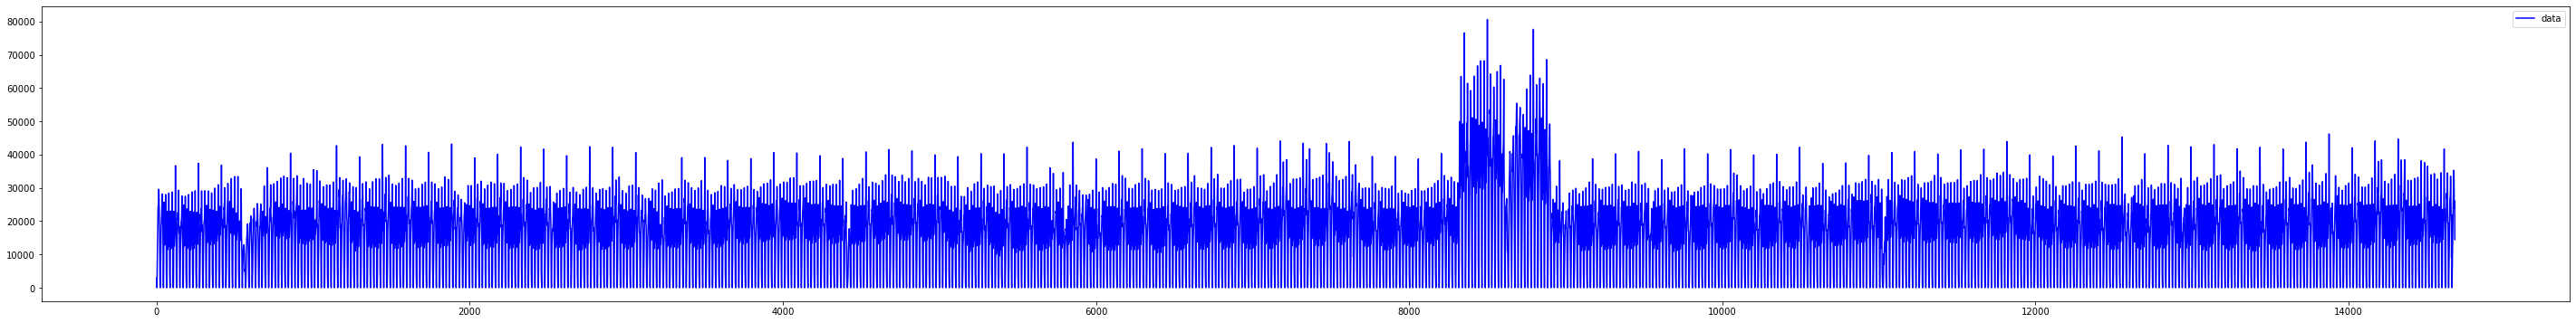

In [5]:
# inv_y與inv_yhat畫圖
# plot baseline and predictions
plt.figure(figsize=(50,6))
plt.plot(MRT_8cluster_6_train_0['Sum_people'], label='data',color = 'blue')
#plt.title('')
plt.legend()
plt.show()

In [94]:
import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(16)

In [95]:
#全部轉成float
values = MRT_8cluster_6_train_0.values
values = values.astype('float32')
values

array([[2.8390e+03, 1.0192e+03, 2.0700e+01, ..., 4.3000e+00, 7.0000e+01,
        1.0000e+00],
       [4.4000e+01, 1.0190e+03, 2.0500e+01, ..., 3.5000e+00, 6.0000e+01,
        1.0000e+00],
       [0.0000e+00, 1.0178e+03, 2.0200e+01, ..., 5.6000e+00, 5.0000e+01,
        1.0000e+00],
       ...,
       [2.3891e+04, 1.0252e+03, 1.6100e+01, ..., 3.4000e+00, 9.0000e+01,
        0.0000e+00],
       [2.6062e+04, 1.0252e+03, 1.6000e+01, ..., 2.8000e+00, 9.0000e+01,
        0.0000e+00],
       [1.4482e+04, 1.0250e+03, 1.6100e+01, ..., 2.9000e+00, 9.0000e+01,
        0.0000e+00]], dtype=float32)

In [96]:
#正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[3.5209347e-02, 8.2558250e-01, 4.2574260e-01, ..., 3.0935255e-01,
        1.9444445e-01, 1.0000000e+00],
       [5.4568908e-04, 8.2170677e-01, 4.1914192e-01, ..., 2.5179857e-01,
        1.6666667e-01, 1.0000000e+00],
       [0.0000000e+00, 7.9845047e-01, 4.0924093e-01, ..., 4.0287772e-01,
        1.3888890e-01, 1.0000000e+00],
       ...,
       [2.9629678e-01, 9.4186020e-01, 2.7392742e-01, ..., 2.4460433e-01,
        2.5000000e-01, 0.0000000e+00],
       [3.2322156e-01, 9.4186020e-01, 2.7062705e-01, ..., 2.0143886e-01,
        2.5000000e-01, 0.0000000e+00],
       [1.7960611e-01, 9.3798637e-01, 2.7392742e-01, ..., 2.0863311e-01,
        2.5000000e-01, 0.0000000e+00]], dtype=float32)

In [97]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 輸入(t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 預測(t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除有空值的行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [98]:
# 前x小時，預測下一個小時
n_hours = 21
n_features = 7

reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()
#reframed.shape

,var1(t-21),var2(t-21),var3(t-21),var4(t-21),var5(t-21),var6(t-21),var7(t-21),var1(t-20),var2(t-20),var3(t-20),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
21,0.035209,0.825583,0.425743,0.575342,0.309353,0.194444,1.0,0.000546,0.821707,0.419142,...,0.035971,0.277778,1.0,0.029914,0.763567,0.399340,0.630137,0.100719,0.555556,1.0
22,0.000546,0.821707,0.419142,0.616438,0.251799,0.166667,1.0,0.000000,0.798450,0.409241,...,0.100719,0.555556,1.0,0.000558,0.761629,0.386139,0.657534,0.107914,0.583333,1.0
23,0.000000,0.798450,0.409241,0.616438,0.402878,0.138889,1.0,0.068112,0.812017,0.402640,...,0.107914,0.583333,1.0,0.000025,0.775194,0.343234,0.726027,0.100719,0.611111,1.0
24,0.068112,0.812017,0.402640,0.643836,0.215827,0.138889,1.0,0.103706,0.825583,0.419142,...,0.100719,0.611111,1.0,0.031948,0.781010,0.336634,0.739726,0.021583,0.555556,1.0
25,0.103706,0.825583,0.419142,0.616438,0.330935,0.138889,1.0,0.157692,0.837210,0.429043,...,0.021583,0.555556,1.0,0.059418,0.796513,0.343234,0.698630,0.071942,0.416667,1.0


In [99]:
# 分割為train及test
values = reframed.values
train_size = int(reframed.shape[0]*0.8) + 1
test_size = int(reframed.shape[0]*0.2)
train = values[:train_size :]
test = values[train_size:, :]
print(train.shape)
print(test.shape)

(11727, 154)
(2931, 154)


In [100]:
# var1~7是變數，var8是target
n_obs = n_hours * n_features

train_X, train_y = train[:, :n_obs], train[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(test_X.shape, len(test_X), test_y.shape)

(11727, 147) 11727 (11727,)
(2931, 147) 2931 (2931,)


In [101]:
min(test_y)

0.0

In [102]:
# 轉成3维狀態 [資料數, 時間步長 ,變量數]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(11727, 21, 7) (11727,)
(2931, 21, 7) (2931,)


In [103]:
test_X.shape[0]

2931

In [104]:
test_X.shape[2]

7

In [105]:
# 建置模型
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                16320     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 16,381
Trainable params: 16,381
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
# 訓練模型
epochs=30
batch_size=72 #每次batch要跑幾筆資料

history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

Train on 11727 samples, validate on 2931 samples
Epoch 1/30
 - 4s - loss: 0.0929 - val_loss: 0.0751
Epoch 2/30
 - 3s - loss: 0.0641 - val_loss: 0.0603
Epoch 3/30
 - 3s - loss: 0.0531 - val_loss: 0.0559
Epoch 4/30
 - 2s - loss: 0.0452 - val_loss: 0.0485
Epoch 5/30
 - 2s - loss: 0.0416 - val_loss: 0.0447
Epoch 6/30
 - 2s - loss: 0.0398 - val_loss: 0.0428
Epoch 7/30
 - 2s - loss: 0.0375 - val_loss: 0.0431
Epoch 8/30
 - 2s - loss: 0.0364 - val_loss: 0.0426
Epoch 9/30
 - 2s - loss: 0.0354 - val_loss: 0.0414
Epoch 10/30
 - 2s - loss: 0.0334 - val_loss: 0.0404
Epoch 11/30
 - 2s - loss: 0.0316 - val_loss: 0.0402
Epoch 12/30
 - 2s - loss: 0.0302 - val_loss: 0.0368
Epoch 13/30
 - 2s - loss: 0.0283 - val_loss: 0.0341
Epoch 14/30
 - 2s - loss: 0.0268 - val_loss: 0.0326
Epoch 15/30
 - 2s - loss: 0.0255 - val_loss: 0.0312
Epoch 16/30
 - 2s - loss: 0.0244 - val_loss: 0.0306
Epoch 17/30
 - 2s - loss: 0.0236 - val_loss: 0.0312
Epoch 18/30
 - 2s - loss: 0.0227 - val_loss: 0.0296
Epoch 19/30
 - 2s - loss

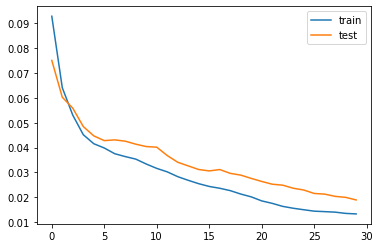

In [107]:
#loss的視覺化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [108]:
# 對test_X預測
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

yhat.shape
test_X.shape

# # 對測試集進行預測
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# yhat.shape

(2931, 147)

In [109]:
min(yhat)

array([-0.02719807], dtype=float32)

>>> a = np.array([[1, 2], [3, 4]])
>>> b = np.array([[5, 6]])
>>> np.concatenate((a, b), axis=0)
array([[1, 2],
       [3, 4],
       [5, 6]])
>>> np.concatenate((a, b.T), axis=1)
array([[1, 2, 5],
       [3, 4, 6]])

In [110]:
# test_X的預測數值，恢復一般數值, inv_yhat
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
len(inv_yhat)

2931

In [111]:
inv_yhat[:300]

array([ 1.74705508e+04,  1.95060469e+04,  1.74998047e+04,  1.56424541e+04,
        1.86187285e+04,  2.35738613e+04,  3.12188105e+04,  2.27020391e+04,
        1.55416797e+04,  1.50215605e+04,  1.56247344e+04,  6.04604004e+03,
        1.10721265e+03,  4.26193756e+02, -4.93613647e+02,  3.31877954e+03,
        1.10236943e+04,  1.92198125e+04,  2.32577109e+04,  1.71775820e+04,
        1.50873193e+04,  1.68960977e+04,  1.91962090e+04,  1.80954570e+04,
        1.71204824e+04,  1.87768984e+04,  2.56145000e+04,  3.22995527e+04,
        2.19477930e+04,  1.62587402e+04,  1.59643701e+04,  1.66395391e+04,
        6.10568750e+03,  1.04634424e+03,  3.78209503e+02, -1.60720490e+02,
        5.25435156e+03,  1.43245244e+04,  2.59092461e+04,  1.82677227e+04,
        1.59842139e+04,  1.55911416e+04,  1.76055039e+04,  1.93443828e+04,
        1.85085938e+04,  1.70604785e+04,  1.96286816e+04,  2.86081621e+04,
        3.58726875e+04,  2.23013418e+04,  1.62671064e+04,  1.59914814e+04,
        1.57360088e+04,  

In [112]:
# # # test_y, 恢復一般數值，inv_y
# # test_y = test_y.reshape((len(test_y), 1))
# # inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
# # inv_y = scaler.inverse_transform(inv_y)
# # inv_y = inv_y[:,7]
# # inv_y

# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# test_y, 恢復一般數值，inv_y
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
len(inv_y)

2931

In [113]:
inv_y[0:300]

array([1.7975000e+04, 1.9064000e+04, 1.6490000e+04, 1.6939000e+04,
       1.8925000e+04, 2.9115000e+04, 3.4426000e+04, 2.2005000e+04,
       1.5809000e+04, 1.5849000e+04, 1.5672001e+04, 4.8290000e+03,
       1.6680000e+03, 2.6999998e+01, 0.0000000e+00, 4.4610000e+03,
       1.3010000e+04, 2.5871002e+04, 1.7826000e+04, 1.4481999e+04,
       1.5194000e+04, 1.7590000e+04, 1.9146000e+04, 1.7521000e+04,
       1.7048000e+04, 1.9805000e+04, 2.8877000e+04, 3.3745000e+04,
       2.2318000e+04, 1.6485000e+04, 1.6496000e+04, 1.5642000e+04,
       5.0130000e+03, 1.6730000e+03, 4.2000004e+01, 6.0000005e+00,
       4.8790000e+03, 1.3321000e+04, 2.6828998e+04, 1.8782000e+04,
       1.5212000e+04, 1.5982000e+04, 1.8462000e+04, 1.9756000e+04,
       1.7910000e+04, 1.7781000e+04, 2.0525000e+04, 3.0066000e+04,
       3.4701000e+04, 2.2724000e+04, 1.6652000e+04, 1.7019000e+04,
       1.6430000e+04, 5.0440000e+03, 2.5680000e+03, 6.1000004e+01,
       2.0000000e+00, 4.8100000e+03, 1.3436001e+04, 2.5855000e

In [114]:
# 計算 RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2297.050


C:\Users\ching\anaconda3\envs\ML_\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 65293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ching\anaconda3\envs\ML_\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 65293 missing from current font.
  font.set_text(s, 0, flags=flags)


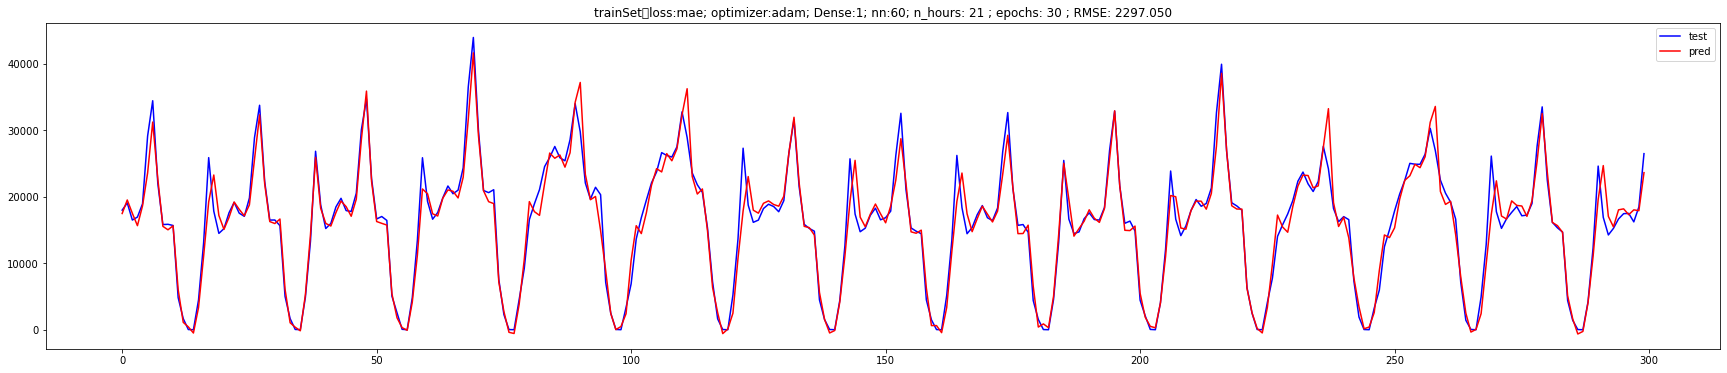

In [115]:
# inv_y與inv_yhat畫圖
# plot baseline and predictions
plt.figure(figsize=(30,6))
plt.plot(inv_y[0:300], label='test',color = 'blue')
plt.plot(inv_yhat[0:300], label='pred', color = 'red')
plt.title('trainSet－loss:mae; optimizer:adam; Dense:1; nn:60; n_hours: 21 ; epochs: 30 ; RMSE: 2297.050')
plt.legend()
plt.show()

In [116]:
#模型存檔
model.save('c86_modle_weights_4.h5')

In [117]:
sum(inv_yhat-inv_y)

-526959.4173002243